In [1]:
!pip install -q jax[cpu] flax optax tensorboard


import jax
import jax.numpy as jnp
from jax import random, vmap, grad, jit
from jax.lib import xla_bridge
import flax.linen as nn
from flax.training import train_state
import optax
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from typing import Tuple, List
import time
from functools import partial


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [2]:
def setup_device():
    devices = jax.devices()
    backend = xla_bridge.get_backend().platform

    print(f"Backend: {backend.upper()}")
    print(f"Available devices: {len(devices)}")
    for i, device in enumerate(devices):
        print(f"  [{i}] {device.device_kind}: {device}")

    # Set default device
    if backend == 'gpu':
        print(f"\n✓ Using GPU acceleration")
        device = devices[0]
    elif backend == 'tpu':
        print(f"\n✓ Using TPU acceleration")
        device = devices[0]
    else:
        print(f"\n⚠ Using CPU only")
        device = devices[0]

    print("="*80 + "\n")
    return device, backend

# Run device setup
device, backend = setup_device()

E0000 00:00:1760593594.747271      10 common_lib.cc:648] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:238


Backend: TPU
Available devices: 8
  [0] TPU v5 lite: TPU_0(process=0,(0,0,0,0))
  [1] TPU v5 lite: TPU_1(process=0,(1,0,0,0))
  [2] TPU v5 lite: TPU_2(process=0,(0,1,0,0))
  [3] TPU v5 lite: TPU_3(process=0,(1,1,0,0))
  [4] TPU v5 lite: TPU_4(process=0,(0,2,0,0))
  [5] TPU v5 lite: TPU_5(process=0,(1,2,0,0))
  [6] TPU v5 lite: TPU_6(process=0,(0,3,0,0))
  [7] TPU v5 lite: TPU_7(process=0,(1,3,0,0))

✓ Using TPU acceleration



/tmp/ipykernel_10/2995828122.py:3: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated and will be removed in JAX v0.8.0; use jax.extend.backend.get_backend.
  backend = xla_bridge.get_backend().platform


In [3]:
class MLP(nn.Module):
    hidden_sizes: List[int]
    use_bfloat16: bool = False

    @nn.compact
    def __call__(self, x):
        # Convert to bfloat16 if requested
        if self.use_bfloat16:
            x = x.astype(jnp.bfloat16)

        for size in self.hidden_sizes:
            x = nn.Dense(size,
                        dtype=jnp.bfloat16 if self.use_bfloat16 else jnp.float32)(x)
            x = jnp.tanh(x)

        # Output layer
        x = nn.Dense(1,
                    dtype=jnp.bfloat16 if self.use_bfloat16 else jnp.float32)(x)
        x = jnp.tanh(x)

        # Convert back to float32 for final output
        if self.use_bfloat16:
            x = x.astype(jnp.float32)
        return x


In [4]:

class EKFTrainer:

    def __init__(self, model, params, R_init=100.0, epsilon=0.01,
                 use_bfloat16=False, device=None):
        self.model = model
        self.use_bfloat16 = use_bfloat16
        self.device = device

        # Flatten parameters
        flat_params, self.unflatten_fn = jax.flatten_util.ravel_pytree(params)
        self.M = len(flat_params)

        print(f"Parameters: {self.M}") #151

        # Initialize P matrix on device
        dtype = jnp.float32  # Always use float32 for stability
        self.P = jax.device_put(jnp.eye(self.M, dtype=dtype) / epsilon, device)
        self.R = jax.device_put(jnp.array(R_init, dtype=dtype), device)

        mem_mb = self.P.nbytes / (1024**2)
        print(f"P matrix: {self.P.dtype}, {mem_mb:.2f} MB")

        # JIT-compiled functions
        self._compute_jacobian = jit(self._jacobian_impl)
        self._single_update = jit(self._update_impl)

    def _jacobian_impl(self, flat_params, x):
        """JIT-compiled Jacobian computation"""
        def output_fn(flat_p):
            params = self.unflatten_fn(flat_p)
            return self.model.apply(params, x).squeeze()

        jac = grad(output_fn)(flat_params)
        return jac.reshape(1, -1)

    def _update_impl(self, flat_params, P, R, x, y_target):
        """JIT-compiled single update step"""
        param_dtype = flat_params.dtype
        P_dtype = P.dtype

        params = self.unflatten_fn(flat_params)
        y_pred = self.model.apply(params, x).squeeze()

        # Compute Jacobian H(n)
        H = self._jacobian_impl(flat_params, x).astype(P_dtype)

        # Kalman gain K(n) = P(n)H(n)[R(n) + H'(n)P(n)H(n)]^-1
        HT = H.T
        temp = H @ P @ HT + R
        K = (P @ HT) / temp

        # Update parameters
        innovation = (y_target.squeeze() - y_pred).astype(param_dtype)
        flat_params_new = flat_params + (K.squeeze().astype(param_dtype) * innovation)

        # Update P(n+1) = P(n) - K(n)H'(n)P(n)
        P_new = P - K @ H @ P
        P_new = 0.5 * (P_new + P_new.T)  # Symmetrize the unequal small values in P & P.T
        P_new = P_new.astype(P_dtype)

        loss = 0.5 * innovation ** 2 # If do P.D. it gives extra factor of 2 to cancel it we mul 0.5
        return flat_params_new, P_new, loss

    @partial(jit, static_argnums=(0,))
    def _batch_update(self, flat_params, P, R, X_batch, y_batch):
        """Vectorized batch update using scan"""
        param_dtype = flat_params.dtype
        P_dtype = P.dtype

        def single_update_scan(carry, xy):
            flat_p, P_curr = carry
            x, y = xy

            x = x.astype(jnp.float32)
            y = y.astype(jnp.float32)

            flat_p_new, P_new, loss = self._update_impl(
                flat_p, P_curr, R, x.reshape(1, -1), y.reshape(1, -1)
            )

            flat_p_new = flat_p_new.astype(param_dtype)
            P_new = P_new.astype(P_dtype)

            return (flat_p_new, P_new), loss

        # Scan through batch
        (flat_params_final, P_final), losses = jax.lax.scan(
            single_update_scan,
            (flat_params, P),
            (X_batch, y_batch)
        )

        return flat_params_final, P_final, jnp.mean(losses)

    def train_epoch(self, flat_params, X_train, y_train, R_decay=1.0, batch_size=32):
        """Train one epoch with batching"""
        n_samples = len(X_train)
        indices = np.random.permutation(n_samples)

        total_loss = 0.0
        n_batches = 0

        for i in range(0, n_samples, batch_size):
            batch_idx = indices[i:min(i+batch_size, n_samples)]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            flat_params, self.P, batch_loss = self._batch_update(
                flat_params, self.P, self.R, X_batch, y_batch
            )
            total_loss += float(batch_loss)
            n_batches += 1

        self.R = self.R * R_decay
        return flat_params, total_loss / n_batches
# R = 100, decay = 0.98 better


In [5]:

def create_train_state(rng, model, learning_rate, input_shape, device):
    params = model.init(rng, jnp.ones(input_shape))
    params = jax.device_put(params, device)
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=tx
    )

@jit
def train_step_bp_single(state, x, y):
    def loss_fn(params):
        pred = state.apply_fn(params, x)
        return jnp.mean((pred - y) ** 2)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jit
def train_step_bp_batch(state, X_batch, y_batch):
    def loss_fn(params):
        # vmap over batch dimension
        pred = vmap(lambda x: state.apply_fn(params, x.reshape(1, -1)))(X_batch)
        return jnp.mean((pred - y_batch) ** 2)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss

def train_epoch_bp(state, X_train, y_train, batch_size=32, use_vmap=True):
    n_samples = len(X_train)
    indices = np.random.permutation(n_samples)

    total_loss = 0.0
    n_batches = 0

    if use_vmap and batch_size > 1:
        # Batched with vmap
        for i in range(0, n_samples, batch_size):
            batch_idx = indices[i:min(i+batch_size, n_samples)]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            state, loss = train_step_bp_batch(state, X_batch, y_batch)
            total_loss += float(loss)
            n_batches += 1
    else:
        # Single sample
        for idx in indices:
            x = X_train[idx:idx+1]
            y = y_train[idx:idx+1]
            state, loss = train_step_bp_single(state, x, y)
            total_loss += float(loss)
            n_batches += 1

    return state, total_loss / n_batches

In [6]:

def generate_regions_data(key, n_samples=1000):
    key_x, key_y = random.split(key)

    x1 = random.uniform(key_x, (n_samples,), minval=-1.0, maxval=1.0)
    x2 = random.uniform(key_y, (n_samples,), minval=-1.0, maxval=1.0)
    X = jnp.column_stack([x1, x2])

    # Vectorized label assignment
    r = jnp.sqrt(jnp.sum(X**2, axis=1))
    labels = jnp.where(r < 0.3, 1,
             jnp.where(r < 0.5, 2,
             jnp.where(r < 0.7, 3, 4)))
    y = jnp.where((labels == 1) | (labels == 3), 0.9, -0.9).reshape(-1, 1)

    return X.astype(jnp.float32), y.astype(jnp.float32)

def generate_xor_data(key, n_samples=1000):
    key_x, key_y = random.split(key)

    x1 = random.uniform(key_x, (n_samples,), minval=-1.0, maxval=1.0)
    x2 = random.uniform(key_y, (n_samples,), minval=-1.0, maxval=1.0)
    X = jnp.column_stack([x1, x2])

    # Vectorized XOR
    x1_pos = X[:, 0] > 0
    x2_pos = X[:, 1] > 0
    labels = (x1_pos & x2_pos) | (~x1_pos & ~x2_pos)
    y = jnp.where(labels, 0.9, -0.9).reshape(-1, 1)

    return X.astype(jnp.float32), y.astype(jnp.float32)


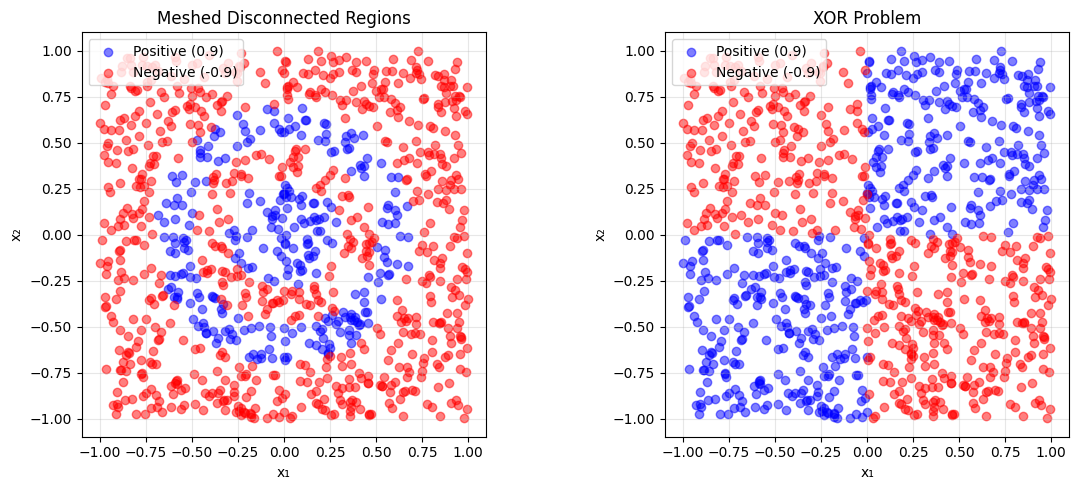

Regions - X shape: (1000, 2), y shape: (1000, 1)
XOR     - X shape: (1000, 2), y shape: (1000, 1)

Regions - Positive samples: 274
XOR     - Positive samples: 507


In [7]:
import matplotlib.pyplot as plt

# Generate datasets
key = random.PRNGKey(42)
X_regions, y_regions = generate_regions_data(key, n_samples=1000)
X_xor, y_xor = generate_xor_data(key, n_samples=1000)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Regions dataset
pos = y_regions.squeeze() > 0
axes[0].scatter(X_regions[pos, 0], X_regions[pos, 1], c='blue', alpha=0.5, label='Positive (0.9)')
axes[0].scatter(X_regions[~pos, 0], X_regions[~pos, 1], c='red', alpha=0.5, label='Negative (-0.9)')
axes[0].set_title('Meshed Disconnected Regions')
axes[0].set_xlabel('x₁')
axes[0].set_ylabel('x₂')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# XOR dataset
pos = y_xor.squeeze() > 0
axes[1].scatter(X_xor[pos, 0], X_xor[pos, 1], c='blue', alpha=0.5, label='Positive (0.9)')
axes[1].scatter(X_xor[~pos, 0], X_xor[~pos, 1], c='red', alpha=0.5, label='Negative (-0.9)')
axes[1].set_title('XOR Problem')
axes[1].set_xlabel('x₁')
axes[1].set_ylabel('x₂')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"Regions - X shape: {X_regions.shape}, y shape: {y_regions.shape}")
print(f"XOR     - X shape: {X_xor.shape}, y shape: {y_xor.shape}")
print(f"\nRegions - Positive samples: {(y_regions > 0).sum()}")
print(f"XOR     - Positive samples: {(y_xor > 0).sum()}")

In [8]:

@partial(jit, static_argnums=(0,))
def compute_rms_error(apply_fn, params, X, y):
    predictions = apply_fn(params, X)
    errors = predictions - y
    return jnp.sqrt(jnp.mean(errors ** 2))

def train_and_compare(
    dataset_name='regions',
    hidden_sizes=[10, 10],
    n_epochs=2000,
    learning_rate_bp=0.1,
    R_init=100.0,
    seed=0,
    use_bfloat16=False,
    ekf_batch_size=32,
    bp_batch_size=32
):

    print(f"\n{'='*80}")
    print(f"EXPERIMENT: {dataset_name.upper()}")
    print(f"Architecture: Input(2) -> Hidden{hidden_sizes} -> Output(1)")
    print(f"Optimizations: bfloat16={use_bfloat16}, device={backend}")
    print(f"Batching: EKF={ekf_batch_size}, BP={bp_batch_size}")
    print(f"{'='*80}\n")

    # Key splitting chain
    rng = random.PRNGKey(seed)
    writer = SummaryWriter(
        f'runs/ekf_vs_bp_{dataset_name}_h{"_".join(map(str, hidden_sizes))}'
    )

    # Generate dataset with proper key
    rng, data_key = random.split(rng)
    print("Generating dataset...")
    if dataset_name == 'regions':
        X_train, y_train = generate_regions_data(data_key, n_samples=1000)
    else:
        X_train, y_train = generate_xor_data(data_key, n_samples=1000)

    # Put data on device
    X_train = jax.device_put(X_train, device)
    y_train = jax.device_put(y_train, device)

    # Create model
    model = MLP(hidden_sizes=hidden_sizes, use_bfloat16=use_bfloat16)

    # Initialize EKF
    print("\nInitializing EKF...")
    rng, ekf_key = random.split(rng)
    params_ekf_init = model.init(ekf_key, jnp.ones((1, 2)))
    params_ekf_init = jax.device_put(params_ekf_init, device)
    flat_params_ekf, _ = jax.flatten_util.ravel_pytree(params_ekf_init)
    ekf_trainer = EKFTrainer(
        model, params_ekf_init, R_init=R_init,
        use_bfloat16=use_bfloat16, device=device
    )

    # Initialize BP
    print("Initializing Backpropagation...")
    rng, bp_key = random.split(rng)
    state_bp = create_train_state(bp_key, model, learning_rate_bp, (1, 2), device)

    # JIT-compiled evaluation
    compute_rms = partial(compute_rms_error, model.apply)

    # Training
    print("\nStarting training...")
    start_time = time.time()

    for epoch in range(n_epochs):
        epoch_start = time.time()

        R_decay = np.exp(-1/50)

        # Train EKF
        flat_params_ekf, loss_ekf = ekf_trainer.train_epoch(
            flat_params_ekf, X_train, y_train, R_decay, ekf_batch_size
        )
        params_ekf = ekf_trainer.unflatten_fn(flat_params_ekf)
        rms_ekf = float(compute_rms(params_ekf, X_train, y_train))

        # Train BP
        state_bp, loss_bp = train_epoch_bp(
            state_bp, X_train, y_train, bp_batch_size, use_vmap=True
        )
        rms_bp = float(compute_rms(state_bp.params, X_train, y_train))

        epoch_time = time.time() - epoch_start

        # TensorBoard logging
        writer.add_scalar('Loss/EKF', loss_ekf, epoch)
        writer.add_scalar('Loss/Backprop', loss_bp, epoch)
        writer.add_scalar('RMS_Error/EKF', rms_ekf, epoch)
        writer.add_scalar('RMS_Error/Backprop', rms_bp, epoch)
        writer.add_scalar('R_value/EKF', float(ekf_trainer.R), epoch)
        writer.add_scalar('Time/epoch_ms', epoch_time*1000, epoch)

        # Print progress
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:4d} | "
                  f"EKF: Loss={loss_ekf:.6f} RMS={rms_ekf:.6f} | "
                  f"BP: Loss={loss_bp:.6f} RMS={rms_bp:.6f} | "
                  f"Time={epoch_time*1000:.1f}ms")

        # Early stopping
        if rms_ekf < 1e-5 and epoch > 10:
            print(f"\nEKF converged at epoch {epoch+1}")
            break

    total_time = time.time() - start_time
    print(f"\nCompleted in {total_time:.2f}s")
    print(f"Final: EKF RMS={rms_ekf:.6f}, BP RMS={rms_bp:.6f}")

    writer.close()

    return {
        'params_ekf': params_ekf,
        'params_bp': state_bp.params,
        'rms_ekf': rms_ekf,
        'rms_bp': rms_bp,
        'epochs': epoch + 1,
        'time': total_time
    }


In [9]:

results_regions = train_and_compare(
    dataset_name='regions',
    hidden_sizes=[10, 10],
    n_epochs=2000,
    learning_rate_bp=0.1,
    R_init=100.0,
    seed=42,
    use_bfloat16=True,
    ekf_batch_size=64,
    bp_batch_size=64
)

print("EXPERIMENT 1 RESULTS:")
print(f"  EKF - Final RMS: {results_regions['rms_ekf']:.6f}")
print(f"  BP  - Final RMS: {results_regions['rms_bp']:.6f}")
print(f"  Epochs: {results_regions['epochs']}")
print(f"  Time: {results_regions['time']:.2f}s")


EXPERIMENT: REGIONS
Architecture: Input(2) -> Hidden[10, 10] -> Output(1)
Optimizations: bfloat16=True, device=tpu
Batching: EKF=64, BP=64

Generating dataset...

Initializing EKF...
Parameters: 151
P matrix: float32, 0.09 MB
Initializing Backpropagation...

Starting training...
Epoch    1 | EKF: Loss=0.234673 RMS=0.645862 | BP: Loss=0.664023 RMS=0.773987 | Time=1658.7ms
Epoch  100 | EKF: Loss=0.011659 RMS=0.153721 | BP: Loss=0.626744 RMS=0.781176 | Time=88.5ms
Epoch  200 | EKF: Loss=0.006039 RMS=0.107696 | BP: Loss=0.627072 RMS=0.786466 | Time=86.6ms
Epoch  300 | EKF: Loss=0.003570 RMS=0.083939 | BP: Loss=0.648537 RMS=0.795914 | Time=81.0ms
Epoch  400 | EKF: Loss=1.089570 RMS=1.475534 | BP: Loss=0.636744 RMS=0.787773 | Time=86.6ms
Epoch  500 | EKF: Loss=1.089570 RMS=1.475534 | BP: Loss=0.623577 RMS=0.793674 | Time=83.8ms
Epoch  600 | EKF: Loss=1.082188 RMS=1.475534 | BP: Loss=0.623397 RMS=0.790792 | Time=91.6ms
Epoch  700 | EKF: Loss=1.094844 RMS=1.475534 | BP: Loss=0.718227 RMS=0.82

In [10]:

results_xor_2 = train_and_compare(
    dataset_name='xor',
    hidden_sizes=[2],
    n_epochs=2000,
    learning_rate_bp=0.1,
    R_init=100.0,
    seed=42,
    use_bfloat16=True,
    ekf_batch_size=64,
    bp_batch_size=64
)

print("EXPERIMENT 2a RESULTS:")
print(f"  EKF - Final RMS: {results_xor_2['rms_ekf']:.6f}")
print(f"  BP  - Final RMS: {results_xor_2['rms_bp']:.6f}")
print(f"  Epochs: {results_xor_2['epochs']}")
print(f"  Time: {results_xor_2['time']:.2f}s")


EXPERIMENT: XOR
Architecture: Input(2) -> Hidden[2] -> Output(1)
Optimizations: bfloat16=True, device=tpu
Batching: EKF=64, BP=64

Generating dataset...

Initializing EKF...
Parameters: 9
P matrix: float32, 0.00 MB
Initializing Backpropagation...

Starting training...
Epoch    1 | EKF: Loss=0.299685 RMS=0.723427 | BP: Loss=0.841796 RMS=0.903436 | Time=959.0ms
Epoch  100 | EKF: Loss=0.235246 RMS=0.684875 | BP: Loss=0.813590 RMS=0.924800 | Time=78.7ms
Epoch  200 | EKF: Loss=0.229298 RMS=0.677418 | BP: Loss=0.815563 RMS=0.901253 | Time=84.5ms
Epoch  300 | EKF: Loss=0.226037 RMS=0.672224 | BP: Loss=0.814622 RMS=0.900059 | Time=90.6ms
Epoch  400 | EKF: Loss=0.226750 RMS=0.669095 | BP: Loss=0.810578 RMS=0.899920 | Time=84.1ms
Epoch  500 | EKF: Loss=0.688086 RMS=1.175388 | BP: Loss=0.811503 RMS=0.900935 | Time=85.9ms
Epoch  600 | EKF: Loss=0.696523 RMS=1.175388 | BP: Loss=0.814962 RMS=0.902164 | Time=88.8ms
Epoch  700 | EKF: Loss=0.691250 RMS=1.175388 | BP: Loss=0.810205 RMS=0.899195 | Time=

In [11]:

results_xor_3 = train_and_compare(
    dataset_name='xor',
    hidden_sizes=[3],
    n_epochs=2000,
    learning_rate_bp=0.1,
    R_init=100.0,
    seed=42,
    use_bfloat16=True,
    ekf_batch_size=64,
    bp_batch_size=64
)

print(f"  EKF - Final RMS: {results_xor_3['rms_ekf']:.6f}")
print(f"  BP  - Final RMS: {results_xor_3['rms_bp']:.6f}")
print(f"  Epochs: {results_xor_3['epochs']}")
print(f"  Time: {results_xor_3['time']:.2f}s")


EXPERIMENT: XOR
Architecture: Input(2) -> Hidden[3] -> Output(1)
Optimizations: bfloat16=True, device=tpu
Batching: EKF=64, BP=64

Generating dataset...

Initializing EKF...
Parameters: 13
P matrix: float32, 0.00 MB
Initializing Backpropagation...

Starting training...
Epoch    1 | EKF: Loss=0.158299 RMS=0.453327 | BP: Loss=0.829535 RMS=0.950354 | Time=978.5ms
Epoch  100 | EKF: Loss=0.052202 RMS=0.321804 | BP: Loss=0.812826 RMS=0.898861 | Time=87.1ms
Epoch  200 | EKF: Loss=0.041124 RMS=0.285518 | BP: Loss=0.833750 RMS=0.904494 | Time=86.7ms
Epoch  300 | EKF: Loss=0.034089 RMS=0.256567 | BP: Loss=0.812763 RMS=0.908143 | Time=89.9ms
Epoch  400 | EKF: Loss=0.027082 RMS=0.236991 | BP: Loss=0.811439 RMS=0.898056 | Time=95.0ms
Epoch  500 | EKF: Loss=0.022965 RMS=0.211168 | BP: Loss=0.813871 RMS=0.900602 | Time=87.9ms
Epoch  600 | EKF: Loss=0.020626 RMS=0.204721 | BP: Loss=0.810755 RMS=0.900379 | Time=91.0ms
Epoch  700 | EKF: Loss=1.001719 RMS=1.414947 | BP: Loss=0.813953 RMS=0.899546 | Time

In [12]:

results_xor_4 = train_and_compare(
    dataset_name='xor',
    hidden_sizes=[4],
    n_epochs=2000,
    learning_rate_bp=0.1,
    R_init=100.0,
    seed=42,
    use_bfloat16=True,
    ekf_batch_size=64,
    bp_batch_size=64
)


print("EXPERIMENT 2c RESULTS:")
print(f"  EKF - Final RMS: {results_xor_4['rms_ekf']:.6f}")
print(f"  BP  - Final RMS: {results_xor_4['rms_bp']:.6f}")
print(f"  Epochs: {results_xor_4['epochs']}")
print(f"  Time: {results_xor_4['time']:.2f}s")


EXPERIMENT: XOR
Architecture: Input(2) -> Hidden[4] -> Output(1)
Optimizations: bfloat16=True, device=tpu
Batching: EKF=64, BP=64

Generating dataset...

Initializing EKF...
Parameters: 17
P matrix: float32, 0.00 MB
Initializing Backpropagation...

Starting training...
Epoch    1 | EKF: Loss=0.119014 RMS=0.370605 | BP: Loss=0.826217 RMS=0.899076 | Time=980.0ms
Epoch  100 | EKF: Loss=0.023307 RMS=0.215106 | BP: Loss=0.822771 RMS=0.904106 | Time=97.1ms
Epoch  200 | EKF: Loss=0.017743 RMS=0.189476 | BP: Loss=0.818214 RMS=0.903453 | Time=76.0ms
Epoch  300 | EKF: Loss=0.014794 RMS=0.170394 | BP: Loss=0.830387 RMS=0.924035 | Time=85.0ms
Epoch  400 | EKF: Loss=0.011764 RMS=0.154720 | BP: Loss=0.814889 RMS=0.904180 | Time=83.6ms
Epoch  500 | EKF: Loss=0.009689 RMS=0.138118 | BP: Loss=0.814687 RMS=0.899934 | Time=86.4ms
Epoch  600 | EKF: Loss=0.008075 RMS=0.121324 | BP: Loss=0.812143 RMS=0.901319 | Time=88.6ms
Epoch  700 | EKF: Loss=0.006506 RMS=0.112921 | BP: Loss=0.814416 RMS=0.900052 | Time

In [13]:

# Load TensorBoard extension
%load_ext tensorboard

# Launch TensorBoard
%tensorboard --logdir runs/


In [14]:

# CUSTOM_CONFIG = {
#     'dataset_name': 'regions',      # 'regions' or 'xor'
#     'hidden_sizes': [5, 5],         # List of hidden layer sizes, e.g., [10, 10] or [5]
#     'n_epochs': 1000,               # Number of training epochs
#     'learning_rate_bp': 0.1,        # Learning rate for backpropagation
#     'R_init': 100.0,                # Initial R value for EKF
#     'seed': 123,                    # Random seed
#     'use_bfloat16': True,          # Use bfloat16 for memory efficiency
#     'ekf_batch_size': 64,           # Batch size for EKF
#     'bp_batch_size': 64             # Batch size for backprop
# }


# for key, value in CUSTOM_CONFIG.items():
#     print(f"  {key}: {value}")

# results_custom = train_and_compare(**CUSTOM_CONFIG)

# print(f"  EKF - Final RMS: {results_custom['rms_ekf']:.6f}")
# print(f"  BP  - Final RMS: {results_custom['rms_bp']:.6f}")
# print(f"  Epochs: {results_custom['epochs']}")
# print(f"  Time: {results_custom['time']:.2f}s")
# print(f"  Winner: {'EKF' if results_custom['rms_ekf'] < results_custom['rms_bp'] else 'Backprop'}")

# Visualization

In [15]:

def compare_boundaries_side_by_side(model, params_ekf, params_bp, 
                                    X_data, y_data, epoch, 
                                    rms_ekf, rms_bp,
                                    dataset_name='regions'):
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Create mesh grid
    resolution = 200
    x_min, x_max = -1.0, 1.0
    y_min, y_max = -1.0, 1.0
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    
    grid_points = jnp.column_stack([xx.ravel(), yy.ravel()])
    
    # Separate positive and negative samples
    pos_mask = y_data.squeeze() > 0
    neg_mask = ~pos_mask
    
    # Process both models
    for idx, (params, method_name, rms, ax) in enumerate([
        (params_ekf, 'EKF', rms_ekf, axes[0]),
        (params_bp, 'Backpropagation', rms_bp, axes[1])
    ]):
        # Predict on grid
        predictions = []
        batch_size = 1000
        for i in range(0, len(grid_points), batch_size):
            batch = grid_points[i:i+batch_size]
            batch_preds = model.apply(params, batch)
            predictions.append(batch_preds)
        
        predictions = jnp.concatenate(predictions, axis=0)
        Z = predictions.reshape(xx.shape)
        
        # Plot decision boundary
        contour = ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
        ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2.5)
        
        # Plot training data
        ax.scatter(X_data[pos_mask, 0], X_data[pos_mask, 1], 
                  c='blue', marker='o', s=30, edgecolors='k', 
                  label='Positive (y=0.9)', alpha=0.7)
        ax.scatter(X_data[neg_mask, 0], X_data[neg_mask, 1], 
                  c='red', marker='s', s=30, edgecolors='k', 
                  label='Negative (y=-0.9)', alpha=0.7)
        
        ax.set_xlabel('x₁', fontsize=12)
        ax.set_ylabel('x₂', fontsize=12)
        ax.set_title(f'{method_name} - Epoch {epoch}\nRMS Error: {rms:.6f}', 
                    fontsize=13, fontweight='bold')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_aspect('equal')
    
    plt.suptitle(f'{dataset_name.upper()} Dataset - Decision Boundaries', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def visualize_training_progression(model, params_history_ekf, params_history_bp,
                                   X_data, y_data, epochs_to_show, 
                                   rms_history_ekf, rms_history_bp,
                                   dataset_name='regions'):
    n_epochs = len(epochs_to_show)
    fig, axes = plt.subplots(2, n_epochs, figsize=(5*n_epochs, 10))
    
    if n_epochs == 1:
        axes = axes.reshape(-1, 1)
    
    # Create mesh grid
    resolution = 150
    xx, yy = np.meshgrid(
        np.linspace(-1.0, 1.0, resolution),
        np.linspace(-1.0, 1.0, resolution)
    )
    grid_points = jnp.column_stack([xx.ravel(), yy.ravel()])
    
    pos_mask = y_data.squeeze() > 0
    neg_mask = ~pos_mask
    
    for col_idx, (epoch_idx, epoch_num) in enumerate(zip(range(n_epochs), epochs_to_show)):
        for row_idx, (params, method_name, rms_history) in enumerate([
            (params_history_ekf[epoch_idx], 'EKF', rms_history_ekf),
            (params_history_bp[epoch_idx], 'BP', rms_history_bp)
        ]):
            ax = axes[row_idx, col_idx]
            
            # Predict on grid
            predictions = []
            batch_size = 1000
            for i in range(0, len(grid_points), batch_size):
                batch = grid_points[i:i+batch_size]
                batch_preds = model.apply(params, batch)
                predictions.append(batch_preds)
            
            predictions = jnp.concatenate(predictions, axis=0)
            Z = predictions.reshape(xx.shape)
            
            # Plot
            ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
            ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
            
            ax.scatter(X_data[pos_mask, 0], X_data[pos_mask, 1], 
                      c='blue', marker='o', s=20, edgecolors='k', alpha=0.6)
            ax.scatter(X_data[neg_mask, 0], X_data[neg_mask, 1], 
                      c='red', marker='s', s=20, edgecolors='k', alpha=0.6)
            
            rms = rms_history[epoch_idx]
            ax.set_title(f'{method_name} - Epoch {epoch_num}\nRMS: {rms:.4f}', 
                        fontsize=11, fontweight='bold')
            ax.set_xlabel('x₁', fontsize=10)
            ax.set_ylabel('x₂', fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal')
    
    plt.suptitle(f'{dataset_name.upper()} Dataset - Training Progression', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [16]:

def quick_visualize(results, epoch_idx=None):
    if epoch_idx is None:
        epoch_idx = -1  # Last epoch
    
    compare_boundaries_side_by_side(
        model=results['model'],
        params_ekf=results['params_history_ekf'][epoch_idx],
        params_bp=results['params_history_bp'][epoch_idx],
        X_data=results['X_train'],
        y_data=results['y_train'],
        epoch=results['actual_epochs'][epoch_idx],
        rms_ekf=results['rms_history_ekf'][epoch_idx],
        rms_bp=results['rms_history_bp'][epoch_idx],
        dataset_name='Dataset'
    )

In [19]:
def train_and_compare_with_visualization(
    dataset_name='xor',
    hidden_sizes=[4],
    n_epochs=2000,
    learning_rate_bp=0.1,
    R_init=100.0,
    seed=0,
    use_bfloat16=True,
    ekf_batch_size=64,
    bp_batch_size=64,
    visualize_at_epochs=[0, 100, 600, 800, 1000]
):

    print(f"EXPERIMENT WITH VISUALIZATION: {dataset_name.upper()}")
    print(f"Architecture: Input(2) -> Hidden{hidden_sizes} -> Output(1)")
    print(f"Visualization epochs: {visualize_at_epochs}")

    # Key splitting chain
    rng = random.PRNGKey(seed)
    writer = SummaryWriter(
        f'runs/ekf_vs_bp_{dataset_name}_h{"_".join(map(str, hidden_sizes))}'
    )

    # Generate dataset
    rng, data_key = random.split(rng)
    print("Generating dataset...")
    if dataset_name == 'regions':
        X_train, y_train = generate_regions_data(data_key, n_samples=1000)
    else:
        X_train, y_train = generate_xor_data(data_key, n_samples=1000)

    # Put data on device
    X_train = jax.device_put(X_train, device)
    y_train = jax.device_put(y_train, device)

    # Create model
    model = MLP(hidden_sizes=hidden_sizes, use_bfloat16=use_bfloat16)

    # Initialize EKF
    print("\nInitializing EKF...")
    rng, ekf_key = random.split(rng)
    params_ekf_init = model.init(ekf_key, jnp.ones((1, 2)))
    params_ekf_init = jax.device_put(params_ekf_init, device)
    flat_params_ekf, _ = jax.flatten_util.ravel_pytree(params_ekf_init)
    ekf_trainer = EKFTrainer(
        model, params_ekf_init, R_init=R_init,
        use_bfloat16=use_bfloat16, device=device
    )

    # Initialize BP
    print("Initializing Backpropagation...")
    rng, bp_key = random.split(rng)
    state_bp = create_train_state(bp_key, model, learning_rate_bp, (1, 2), device)

    # JIT-compiled evaluation
    compute_rms = partial(compute_rms_error, model.apply)

    # Storage for visualization
    params_history_ekf = []
    params_history_bp = []
    rms_history_ekf = []
    rms_history_bp = []
    actual_epochs = []

    # Training
    print("\nStarting training...")
    start_time = time.time()

    for epoch in range(n_epochs):
        epoch_start = time.time()

        R_decay = np.exp(-1/50)

        # Train EKF
        flat_params_ekf, loss_ekf = ekf_trainer.train_epoch(
            flat_params_ekf, X_train, y_train, R_decay, ekf_batch_size
        )
        params_ekf = ekf_trainer.unflatten_fn(flat_params_ekf)
        rms_ekf = float(compute_rms(params_ekf, X_train, y_train))

        # Train BP
        state_bp, loss_bp = train_epoch_bp(
            state_bp, X_train, y_train, bp_batch_size, use_vmap=True
        )
        rms_bp = float(compute_rms(state_bp.params, X_train, y_train))

        epoch_time = time.time() - epoch_start

        # Save parameters for visualization
        if epoch in visualize_at_epochs or epoch == n_epochs - 1:
            print(f"\nSaving snapshot at epoch {epoch}...")
            # FIXED: Use jax.tree_util.tree_map instead of jax.tree_map
            params_history_ekf.append(jax.tree_util.tree_map(lambda x: np.array(x), params_ekf))
            params_history_bp.append(jax.tree_util.tree_map(lambda x: np.array(x), state_bp.params))
            rms_history_ekf.append(rms_ekf)
            rms_history_bp.append(rms_bp)
            actual_epochs.append(epoch)

        # TensorBoard logging
        writer.add_scalar('Loss/EKF', loss_ekf, epoch)
        writer.add_scalar('Loss/Backprop', loss_bp, epoch)
        writer.add_scalar('RMS_Error/EKF', rms_ekf, epoch)
        writer.add_scalar('RMS_Error/Backprop', rms_bp, epoch)
        writer.add_scalar('R_value/EKF', float(ekf_trainer.R), epoch)
        writer.add_scalar('Time/epoch_ms', epoch_time*1000, epoch)

        # Print progress
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:4d} | "
                  f"EKF: Loss={loss_ekf:.6f} RMS={rms_ekf:.6f} | "
                  f"BP: Loss={loss_bp:.6f} RMS={rms_bp:.6f} | "
                  f"Time={epoch_time*1000:.1f}ms")

        # Early stopping
        if rms_ekf < 1e-5 and epoch > 10:
            print(f"\nEKF converged at epoch {epoch+1}")
            # Save final snapshot if not already saved
            if epoch not in visualize_at_epochs:
                params_history_ekf.append(jax.tree_util.tree_map(lambda x: np.array(x), params_ekf))
                params_history_bp.append(jax.tree_util.tree_map(lambda x: np.array(x), state_bp.params))
                rms_history_ekf.append(rms_ekf)
                rms_history_bp.append(rms_bp)
                actual_epochs.append(epoch)
            break

    total_time = time.time() - start_time
    print(f"\nCompleted in {total_time:.2f}s")
    print(f"Final: EKF RMS={rms_ekf:.6f}, BP RMS={rms_bp:.6f}")

    writer.close()

    
    visualize_training_progression(
        model, params_history_ekf, params_history_bp,
        X_train, y_train, actual_epochs,
        rms_history_ekf, rms_history_bp,
        dataset_name=dataset_name
    )

    return {
        'params_ekf': params_ekf,
        'params_bp': state_bp.params,
        'rms_ekf': rms_ekf,
        'rms_bp': rms_bp,
        'epochs': epoch + 1,
        'time': total_time,
        'params_history_ekf': params_history_ekf,
        'params_history_bp': params_history_bp,
        'rms_history_ekf': rms_history_ekf,
        'rms_history_bp': rms_history_bp,
        'actual_epochs': actual_epochs,
        'model': model,
        'X_train': X_train,
        'y_train': y_train
    }

EXPERIMENT WITH VISUALIZATION: XOR
Architecture: Input(2) -> Hidden[4] -> Output(1)
Visualization epochs: [0, 200, 400, 600, 800, 1000]
Generating dataset...

Initializing EKF...
Parameters: 17
P matrix: float32, 0.00 MB
Initializing Backpropagation...

Starting training...

Saving snapshot at epoch 0...
Epoch    1 | EKF: Loss=0.187147 RMS=0.531982 | BP: Loss=0.829576 RMS=0.909524 | Time=879.0ms
Epoch  100 | EKF: Loss=0.027984 RMS=0.234859 | BP: Loss=0.823589 RMS=0.897583 | Time=89.3ms
Epoch  200 | EKF: Loss=0.020737 RMS=0.204316 | BP: Loss=0.817355 RMS=0.900615 | Time=83.7ms

Saving snapshot at epoch 200...
Epoch  300 | EKF: Loss=0.016772 RMS=0.182767 | BP: Loss=0.815670 RMS=0.903488 | Time=82.4ms
Epoch  400 | EKF: Loss=0.013888 RMS=0.165757 | BP: Loss=0.813641 RMS=0.903183 | Time=83.2ms

Saving snapshot at epoch 400...
Epoch  500 | EKF: Loss=0.011443 RMS=0.151014 | BP: Loss=0.812992 RMS=0.902057 | Time=84.3ms
Epoch  600 | EKF: Loss=0.008589 RMS=0.131842 | BP: Loss=0.820681 RMS=0.9030

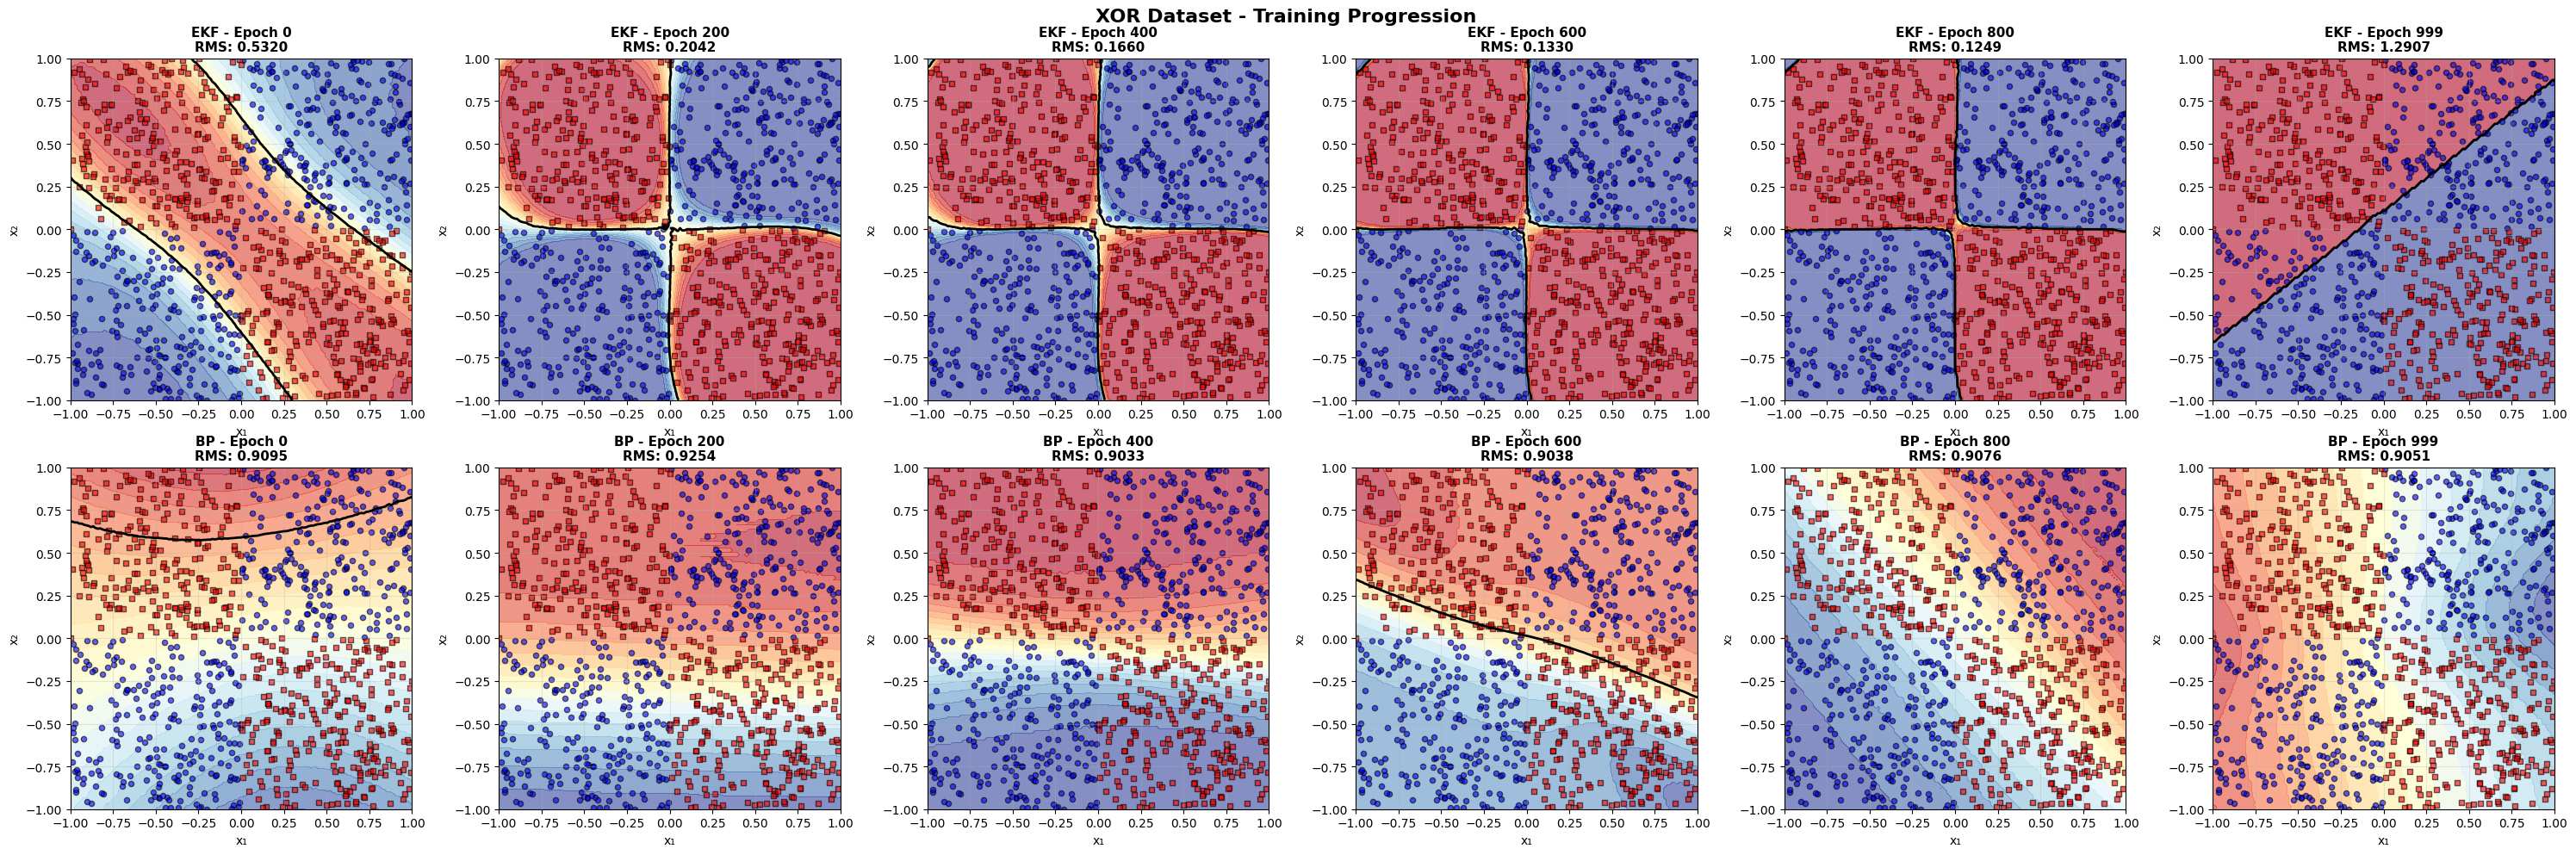


Final Results:
  EKF RMS: 1.290736
  BP RMS:  0.905079


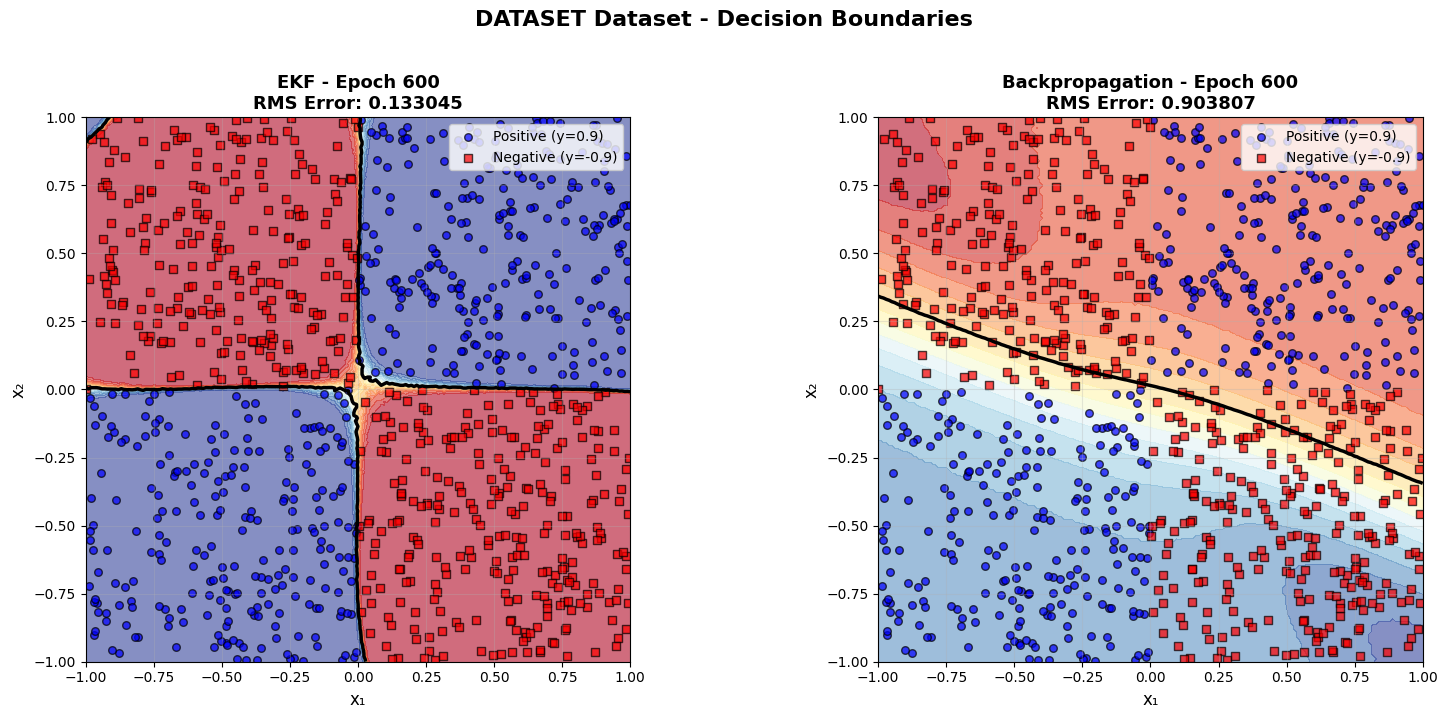

In [20]:

results = train_and_compare_with_visualization(
    dataset_name='xor',
    hidden_sizes=[4],
    n_epochs=1000,
    learning_rate_bp=0.1,
    R_init=100.0,
    seed=42,
    use_bfloat16=True,
    ekf_batch_size=64,
    bp_batch_size=64,
    visualize_at_epochs=[0, 200, 400, 600, 800, 1000]
)

print(f"\nFinal Results:")
print(f"  EKF RMS: {results['rms_ekf']:.6f}")
print(f"  BP RMS:  {results['rms_bp']:.6f}")

# View specific epoch
quick_visualize(results, epoch_idx=3)  # 3rd index = 600